In [106]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
ofi = pd.read_csv('../data_cleaned/ofi_10_levels.csv')
OFI_values = ofi.drop(['mid_price_delta', 'time_bin', 'bin_label'], axis=1)

In [109]:
ofi.columns

Index(['time_bin', 'bin_label', 'OFI_0', 'OFI_1', 'OFI_2', 'OFI_3', 'OFI_4',
       'OFI_5', 'OFI_6', 'OFI_7', 'OFI_8', 'OFI_9', 'mid_price_delta'],
      dtype='object')

In [4]:
#clean outliers 
nsigma=2
for c in ofi.columns[2:]:
    mean=ofi[c].mean()
    std=ofi[c].std()
    ofi[c]=ofi[c].apply(lambda x: np.NaN if np.abs(x-mean)>nsigma*std else x)
ofi=ofi.dropna()
ofi.index=range(len(ofi))

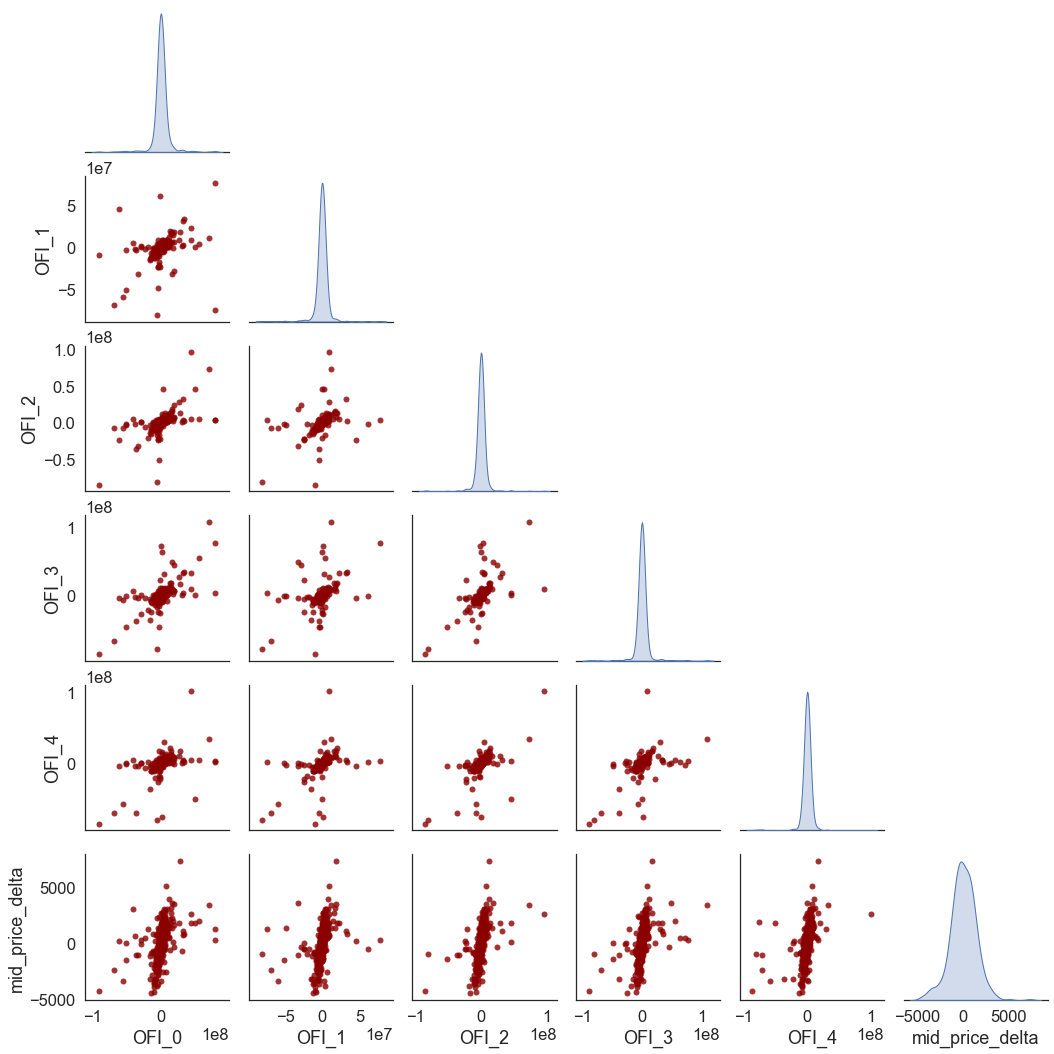

In [117]:
sns.pairplot(data=ofi, vars=['OFI_0', 'OFI_1', 'OFI_2', 'OFI_3', 'OFI_4',
        'mid_price_delta'], corner=True, diag_kind='kde', 
        plot_kws={'alpha':0.8, 'linewidth':0, 'color':'darkred', 'facecolor':'darkred'})

## Outlier detection with Isolation Forest and Linear Fit

In [55]:
from sklearn.ensemble import IsolationForest
import numpy as np

Fitting level 0
Fitting level 1
Fitting level 2
Fitting level 3
Fitting level 4
Fitting level 5


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

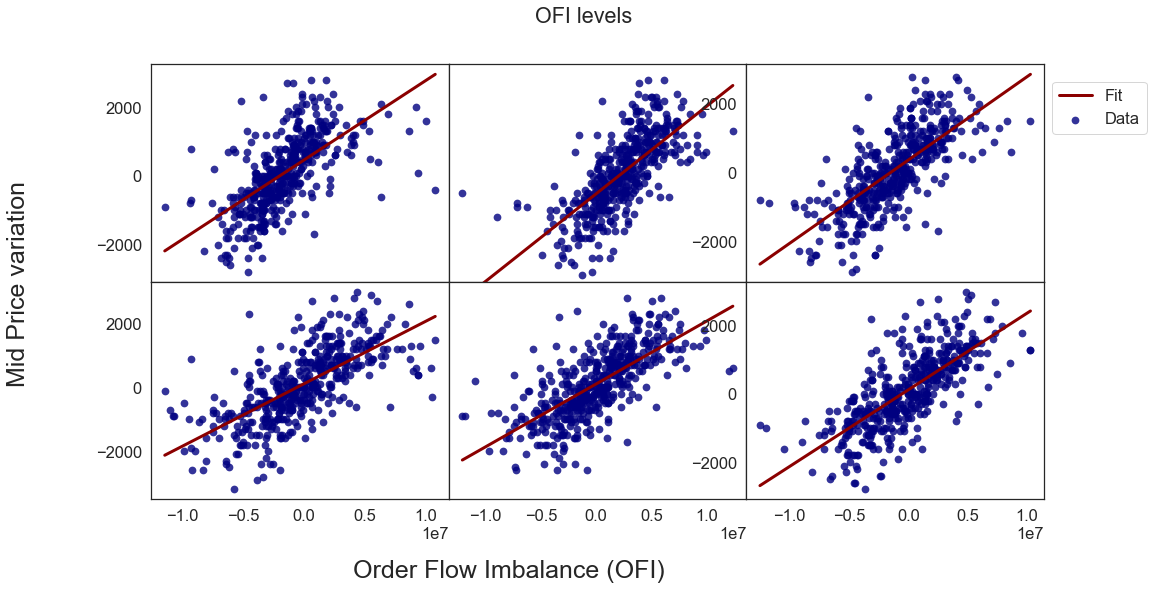

In [147]:
n_fit = 6
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16,8))
sns.set_theme(style='white', font_scale=1.5)
j=0
k=0
a_coeff, b_coeff, r2_scores = [], [], []
for i in range(n_fit):
    print('Fitting level {}'.format(i))

    if i==3: 
        j=0
        k=1
    #removing outliers 
    trend_data = np.array([ofi['OFI_{}'.format(i)], ofi['mid_price_delta']], dtype=np.float64).T
    clf = IsolationForest(n_estimators=100)
    clf.fit(trend_data)   
    outliers = [True if x==1 else False for x in clf.predict(trend_data)]
    trend_data=trend_data[outliers].T

    # linear fit
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score
    model=LinearRegression()
    model.fit(trend_data[0].reshape(-1,1),trend_data[1])
    a, b = model.coef_[0], model.intercept_
    a_coeff.append(a)
    b_coeff.append(b)
    # r2_score: proportion of the variation in the dependent 
    # variable that is predictable from the independent variable
    r2_scores.append((r2_score(trend_data[1], model.predict(trend_data[0].reshape(-1,1)))))

    #plot
    predicted=[a*x+b for x in trend_data[0]]
    sns.scatterplot(x=trend_data[0], y=trend_data[1], ax=ax[k,j], \
                    s=60, marker='o', color ='navy',linewidth=0, alpha=0.8, label='Data')
    g=sns.lineplot(x=trend_data[0], y=predicted, ax=ax[k,j], lw=3, color='darkred', label='Fit')

    g.legend(loc='center left', bbox_to_anchor=(1, 0.8))
    if k!=0 and j!=0: ax[k,j].get_legend().remove()

    ax[k,j].set_xlabel('')
    ax[k,j].set_ylabel('')
    j+=1

#Options for the plot
fig.suptitle('OFI levels')
ax[0,0].get_shared_x_axes().join(ax[0,0], ax[1,0])
ax[0,0].set_xticklabels([])
ax[0,1].set_ylim(ax[0,0].get_ylim())
ax[1,1].set_ylim(ax[1,0].get_ylim())
ax[0,1].set_yticklabels('')
ax[1,1].set_yticklabels('')
fig.text(0, 0.5, 'Mid Price variation', rotation=90, va='center', fontsize=25)
fig.text(0.3, 0, 'Order Flow Imbalance (OFI) ', va='center', fontsize=25)
fig.subplots_adjust(hspace=.0, wspace=0.)


#output
import os 
if os.path.isdir('../figures')==False:
    os.mkdir('../figures')
fig.savefig('../figures/OFI_levels_fit.pdf', bbox_inches='tight')

#results
from IPython.display import display, Math
for i in range(n_fit): 
    display(Math(r'Level \,\,{} \quad \quad  \Delta \overline P = {:.4f}\,\, OFI_{} + {:.4f}'+
                ' \quad R^2 = {:.2f}'.format(i, a_coeff[i], i, b_coeff[i], r2_scores[i])))

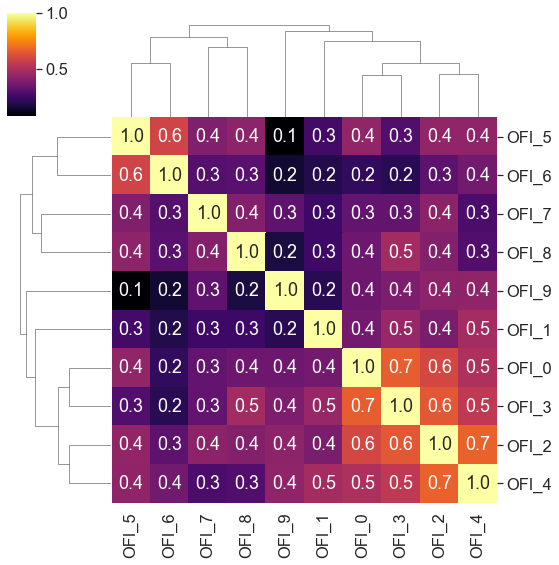

In [153]:
sns.clustermap(OFI_values.corr(), cmap='inferno', figsize=(8,8), annot=True, fmt='.1f')

## Multivariate Time Series Forecasting with LSTMs

In [163]:
from datetime import datetime

time_series = ofi.drop(['bin_label', 'time_bin'], axis=1)
time_series.index.name = 'date'
time_series.index = ofi['time_bin'].apply(lambda x: datetime.strptime(ofi['time_bin'][0][1:27],"%Y-%m-%d %H:%M:%S.%f" ))

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: operands could not be broadcast together with shapes (127,21) (11,) (127,21) 

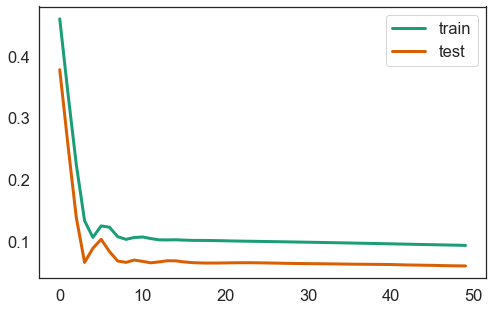

In [177]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = [], []
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	df = pd.concat(cols, axis=1)
	df.columns = names
	df.dropna(inplace=True)
	return df

#preprocessing 
from sklearn.preprocessing import MinMaxScaler #scaling each feature to a given range
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(time_series.values)
data = series_to_supervised(data, 1, 1).values

train_frac = 0.5
val_frac = 0.25
test_frac = 0.25
N_train = int(train_frac*len(time_series))
N_val = int(val_frac*len(time_series))
N_test = int(test_frac*len(time_series))

train = data[:N_train, :]
val = data[N_train:N_train+N_val, :]
test = data[N_train+N_val:, :]

train_data, train_target = train[:, :-1], train[:, -1]
val_data, val_target = val[:, :-1], val[:, -1]
test_data, test_target = test[:, :-1], test[:, -1]

train_data = train_data.reshape((train_data.shape[0], 1, train_data.shape[1]))
val_data = val_data.reshape((val_data.shape[0], 1, val_data.shape[1]))
test_data = test_data.reshape((test_data.shape[0], 1, test_data.shape[1]))

# design network
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(50, input_shape=(train_data.shape[1], train_data.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

fitted = model.fit(train_data, train_target, epochs=50, batch_size=72, 
				validation_data=(val_data, val_target), verbose=0, shuffle=False)
fig, ax = plt.subplots(figsize=(8,5))
sns.set_theme(style='white', font_scale=1.5, palette='Dark2')
sns.lineplot(np.arange(len(fitted.history['loss'])), fitted.history['loss'], label='train', lw=3)
sns.lineplot(np.arange(len(fitted.history['val_loss'])), fitted.history['val_loss'], label='test', lw=3)

# make a prediction
yhat = model.predict(test_data)
test_data = test_data.reshape((test_data.shape[0], test_data.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_data[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_target.reshape((len(test_target), 1))
inv_y = np.concatenate((test_y, test_data[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

[Text(0, -40000000.0, ''),
 Text(0, -30000000.0, ''),
 Text(0, -20000000.0, ''),
 Text(0, -10000000.0, ''),
 Text(0, 0.0, ''),
 Text(0, 10000000.0, ''),
 Text(0, 20000000.0, ''),
 Text(0, 30000000.0, ''),
 Text(0, 40000000.0, '')]

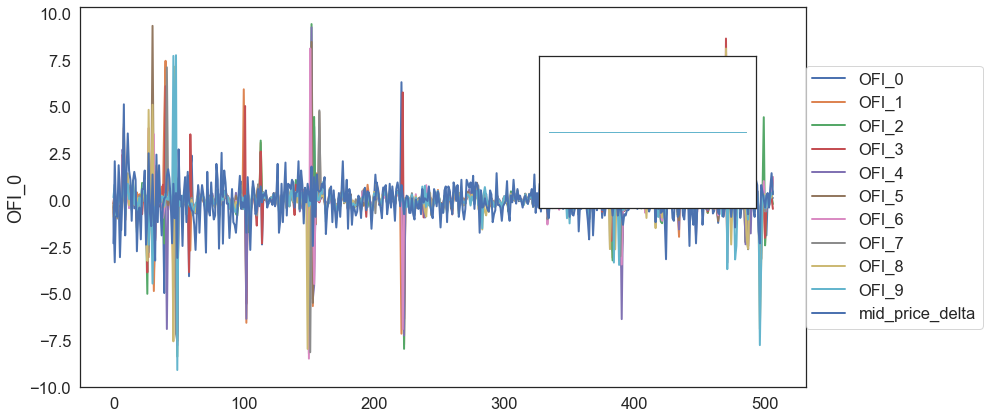

In [160]:
#time evoltion
import matplotlib.pyplot as plt
import seaborn as sns
ms = 0
lw = 2
fig, ax = plt.subplots(figsize=(13,7))

for c in time_series.columns:
    g = sns.lineplot(x=np.arange(len(time_series)), y=time_series[c] , ax=ax, 
                linewidth=lw, marker='o', markersize=ms, label=c)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=0.)

# An inner plot to show the peak frequency
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(ax,  "30%", "40%" ,loc="upper right", borderpad=3)
maxlevel = 10
for l in range(maxlevel):
    g = sns.lineplot(x=np.arange(len(time_series)), y=time_series['OFI_{}'.format(l)] , ax=axins, 
                linewidth=1, marker='o', markersize=ms, label=c)
axins.get_legend().remove()
axins.set_ylim(-3.5e7,3.5e7)
axins.set_ylabel('')
axins.set_xlabel('')
axins.set_xticklabels([])
axins.set_yticklabels([])

<AxesSubplot:>

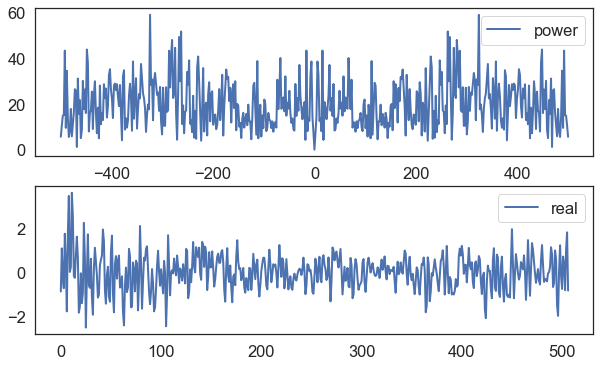

In [161]:
# fft
from scipy.fftpack import fft, fftfreq, ifft
time_step = 1e-3
signal = time_series['mid_price_delta'].to_numpy()
signal_fft = fft(signal)
power = np.abs(signal_fft)
freq = fftfreq(len(signal), d=time_step) 

pos_mask = np.where(freq > 0)
pfreq = freq[pos_mask]
peak_freq = pfreq[power[pos_mask].argmax()]

fcleaned = signal_fft.copy()
fcleaned[(np.abs(freq) )> peak_freq] = 0
cleaned_signal = ifft(fcleaned)
real_signal = np.real(cleaned_signal)


fig, ax = plt.subplots(2, 1, figsize=(10, 6))
sns.set_theme(style='white', font_scale=1.5, palette ='Dark2')
sns.lineplot(x=freq, y=power, ax=ax[0], lw=lw, label='power')
time = np.arange(len(real_signal))

sns.lineplot(x=time, y=real_signal, ax=ax[1], lw=lw, label = 'real')

Epoch 1/50
6/6 - 4s - loss: 0.2940 - val_loss: 0.1864 - 4s/epoch - 633ms/step
Epoch 2/50
6/6 - 0s - loss: 0.1303 - val_loss: 0.0781 - 28ms/epoch - 5ms/step
Epoch 3/50
6/6 - 0s - loss: 0.1002 - val_loss: 0.1078 - 31ms/epoch - 5ms/step
Epoch 4/50
6/6 - 0s - loss: 0.1075 - val_loss: 0.0858 - 42ms/epoch - 7ms/step
Epoch 5/50
6/6 - 0s - loss: 0.0860 - val_loss: 0.0802 - 39ms/epoch - 6ms/step
Epoch 6/50
6/6 - 0s - loss: 0.0907 - val_loss: 0.0853 - 44ms/epoch - 7ms/step
Epoch 7/50
6/6 - 0s - loss: 0.0888 - val_loss: 0.0779 - 68ms/epoch - 11ms/step
Epoch 8/50
6/6 - 0s - loss: 0.0858 - val_loss: 0.0778 - 37ms/epoch - 6ms/step
Epoch 9/50
6/6 - 0s - loss: 0.0859 - val_loss: 0.0772 - 40ms/epoch - 7ms/step
Epoch 10/50
6/6 - 0s - loss: 0.0848 - val_loss: 0.0765 - 39ms/epoch - 7ms/step
Epoch 11/50
6/6 - 0s - loss: 0.0848 - val_loss: 0.0769 - 44ms/epoch - 7ms/step
Epoch 12/50
6/6 - 0s - loss: 0.0849 - val_loss: 0.0758 - 39ms/epoch - 7ms/step
Epoch 13/50
6/6 - 0s - loss: 0.0843 - val_loss: 0.0753 - 41m

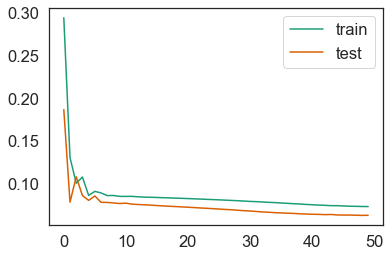

<AxesSubplot:xlabel='OFI_0', ylabel='Count'>

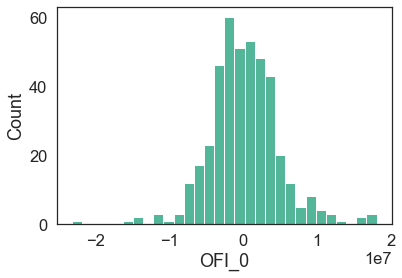

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(x='OFI_0',data=ofi, bins=30)